In [2]:
# Import numpy and matplotlib, and use jupyter magic to
# get plots directly in notebook
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
# Get nicer looking plots than default
plt.style.use('bmh')
# Timer to measure the performance of methods
from time import time
import scipy
from scipy.linalg import lapack

## Jacobi method

In [6]:
def jacobi(A, b, x0, tol):
    # Split A into diagonal and off-diagonal
    I = np.identity(A.shape[0])
    D = A * I # Elementwise multiplication
    E = A - D # A - diagonal = off-diagonal
    # Calculate inverse of D
    # (easy since D is diagonal)
    # If the argument to np.diag is a matrix,
    # it returns a vector with the diagonal elements.
    # If the argument to np.diag is a vector,
    # it returns a square matrix with those elements on the diagonal
    Di = np.diag(1/np.diag(D))
    # Calculate B and z once
    B = -np.dot(Di, E)
    z =  np.dot(Di, b)
    # Store residuals in a list for plotting purposes
    res = np.linalg.norm(b - np.dot(A, x0))
    residuals = [res]
    # Count number of iterations for later comparison
    count = 0
    while res > tol:
        count += 1
        x0 = np.dot(B, x0) + z
        res = np.linalg.norm(b - np.dot(A, x0))
        residuals.append(res)
        print('Residual: %.3e' % res, '\r', end = '')

    return x0, residuals

x =  [[ 1.99999997]
 [-2.        ]]


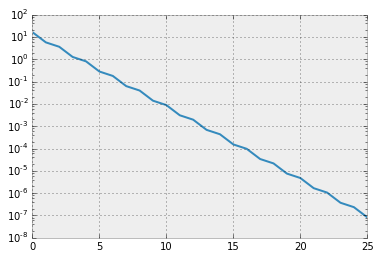

In [8]:
# Example equation system
A = np.array([
        [3, 2],
        [2, 6]
    ])

b = np.array([
        [2], 
        [-8]
    ])

# Initial guess at x
xi = np.array([
        [1],
        [1]
    ])

x, res = jacobi(A, b, xi, 1e-7)
plt.plot(res)
plt.yscale('log')
print('x = ', x)

## Gauss-Seidel

In [9]:
def gaussSeidel(A, b, x0, tol):
    I = np.identity(A.shape[0])
    D = A*I # Elementwise multiplication
    L = np.tril(A, k = -1)
    U = np.triu(A, k =  1)
    # Calculate inverse of L, using a lapack routine
    # specific for triangular matrices.
    # lower = 0 would indicate an upper triangular matrix.
    # info =! 0 indicates something went wrong.
    Li, info = lapack.dtrtri(D+L, lower = 1)
    G  = -np.dot(Li, U)
    z  =  np.dot(Li, b)
    
    res = np.linalg.norm(b - np.dot(A, x0))
    residuals = [res]
    count = 0
    while res > tol:
        count += 1
        x0 = np.dot(G, x0) + z
        res = np.linalg.norm(b - np.dot(A, x0))
        residuals.append(res)
        print('Residual: %.3e' % res, '\r', end = '')

    return x0, residuals

[[ 1.99999997]
 [-1.99999999]]


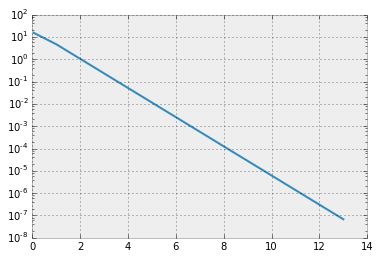

In [11]:
A = np.array([
        [3, 2],
        [2, 6]
    ])

b = np.array([
        [2], 
        [-8]
    ])

# Initial guess at x
xi = np.array([
        [1],
        [1]
    ])

x, res = gaussSeidel(A, b, xi, 1e-7)
plt.plot(res)
plt.yscale('log')
print(x)


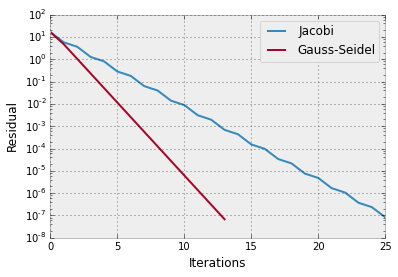

In [15]:
# Comparison of the two methods:

x, res = jacobi(A, b, xi, 1e-7)
plt.plot(res, label = 'Jacobi')
x, res = gaussSeidel(A, b, xi, 1e-7)
plt.plot(res, label = 'Gauss-Seidel')
plt.yscale('log')
plt.ylabel('Residual')
plt.xlabel('Iterations')
plt.legend()

## Successive Over Relaxation (SOR)

In [18]:
def SOR(A, b, x0, tol, w):
    I = np.identity(A.shape[0])
    D = A*I # Elementwise multiplication
    L = np.tril(A, k = -1)
    U = np.triu(A, k =  1)
    Li, info = lapack.dtrtri(D + w*L, lower = 1)
    S = np.dot(-Li, w*U + (w-1)*D)
    z = np.dot(Li, w*b)
    
    res = np.linalg.norm(b - np.dot(A, x0))
    residuals = [res]
    count = 0
    while res > tol:
        count += 1
        x0 = np.dot(S, x0) + z
        res = np.linalg.norm(b - np.dot(A, x0))
        residuals.append(res)
        print('Residual: %.3e' % res, '\r', end = '')

    return x0, residuals

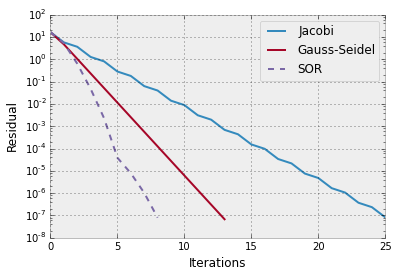

In [20]:
# Comparison of the three methods:
x, res = jacobi(A, b, xi, 1e-7)
plt.plot(res, label = 'Jacobi')
x, res = gaussSeidel(A, b, xi, 1e-7)
plt.plot(res, label = 'Gauss-Seidel')
x, res = SOR(A, b, xi, 1e-7, w = 1.07)
plt.plot(res, '--', label = 'SOR')
plt.yscale('log')
plt.ylabel('Residual')
plt.xlabel('Iterations')
plt.legend()


## Example: Poisson equation

In [29]:
def s(x):
    return x*(x+3)*np.exp(x)

# Decide on discretisation, construct vector of x-values
N  = 50
x  = np.linspace(0, 1, N)
dx = x[1] - x[0]

# Construct A, begin by tridiagonal matrix
# with 2 on diagonal and -1 on the two off-diagonals
# Note that this example explicitly includes the endpoints,
# unlike the example in the slides
A = np.diag(2*np.ones(N)) - np.diag(np.ones(N-1), -1) - np.diag(np.ones(N-1), +1)
# Fix first and last rows to take care of boundary conditions
A[ 0, 0] = 1
A[ 0, 1] = 0
A[-1,-1] = 1
A[-1,-2] = 0

# Construct b
b = -dx**2 * s(x)
# Set first and last element to take care of boundary conditions
# Change these to try different boundary conditions
b[0]  = 0
b[-1] = 0

# Initial guess at phi
phi0 = np.zeros(N)

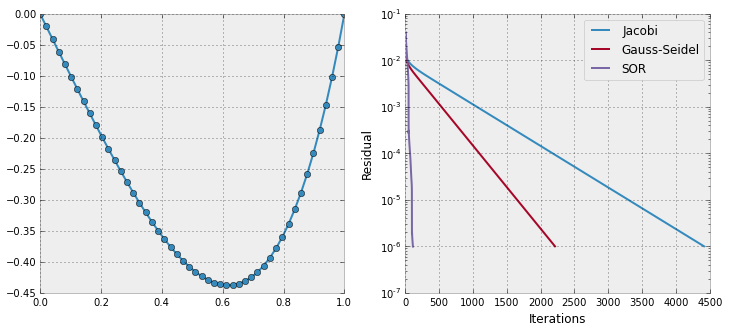

In [37]:
tol = 1e-6
phi, Jres =      jacobi(A, b, phi0, tol = tol)
phi, Gres = gaussSeidel(A, b, phi0, tol = tol)
phi, Sres =         SOR(A, b, phi0, tol = tol, w = 1.9)

# Plot comparison
fig, ax = plt.subplots(ncols = 2, figsize = (12, 5))
ax[0].plot(x, phi, marker = 'o')
ax[1].plot(Jres, label = 'Jacobi')
ax[1].plot(Gres, label = 'Gauss-Seidel')
ax[1].plot(Sres, label = 'SOR')
ax[1].set_yscale('log')
ax[1].set_ylabel('Residual')
ax[1].set_xlabel('Iterations')
ax[1].legend()

## Conjugate Gradient

In [34]:
def cg(A, b, x0, tol):
    r = b - np.dot(A, x0)
    d = r
    N = A.shape[0]
    residuals = []
    # With exact arithmetic, N iterations would be sufficient
    for i in range(2*N):
        # Precalculate Ad
        Ad    = np.dot(A, d)
        alpha = np.dot(r, r) / np.dot(d, Ad)
        x0    = x0 + alpha*d
        # Precalculate denominator of beta before updating r
        den   = np.dot(r, r)
        r     = r  - alpha*Ad
        beta  = np.dot(r, r) / den
        d     = r + np.dot(beta, d)
        
        # Exit loop early if tolerance is reached
        res = np.linalg.norm(r)
        residuals.append(res)
        if res <= tol:
            break
    return x0, residuals

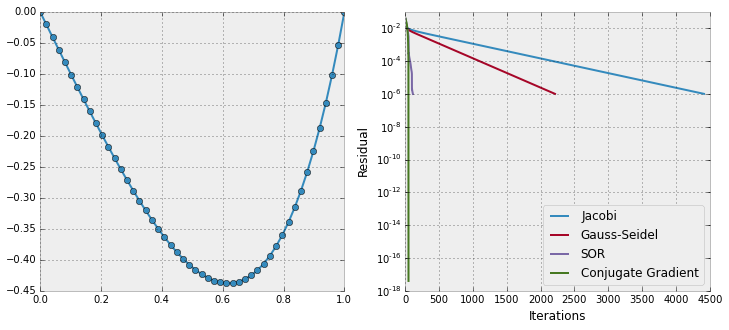

In [41]:

tol = 1e-6
phi, Jres =      jacobi(A, b, phi0, tol = tol)
phi, Gres = gaussSeidel(A, b, phi0, tol = tol)
phi, Sres =         SOR(A, b, phi0, tol = tol, w = 1.9)
phi, Cres =          cg(A, b, phi0, tol = tol)

# Plot comparison
fig, ax = plt.subplots(ncols = 2, figsize = (12, 5))
ax[0].plot(x, phi, marker = 'o')
ax[1].plot(Jres, label = 'Jacobi')
ax[1].plot(Gres, label = 'Gauss-Seidel')
ax[1].plot(Sres, label = 'SOR')
ax[1].plot(Cres, label = 'Conjugate Gradient')
ax[1].set_ylabel('Residual')
ax[1].set_xlabel('Iterations')
ax[1].set_yscale('log')
ax[1].legend(loc = 'lower right')

## BiCGStab
(Bi-Conjugate Gradient Stabilised)

In [42]:
# We use bicgstab from scipy.sparse.linalg
from scipy.sparse import linalg
# Bicgstab doesn't return number of iterations by default
# but you can give it a function that will be called after
# every iteration, so we can use that to count the iterations
# for comparison with the other methods
i = 0
def f(x):
    global i
    i += 1
x, info = linalg.bicgstab(A, b, phi0, tol = 1e-6, callback = f)

print('Number of iterations:')
print('Jacobi:             ', len(Jres))
print('Gauss Seidel:       ', len(Gres))
print('SOR:                ', len(Sres))
print('Conjugate gradient: ', len(Cres))
print('BicGStab:           ', i)

Number of iterations:
Jacobi:              4417
Gauss Seidel:        2214
SOR:                 113
Conjugate gradient:  48
BicGStab:            47


## Example of systems that don't converge

In [48]:
# Function for creating a test matrix
# Larger tau makes the matrix more difficult to solve

def getA(N, tau):
    # Construct test matrix according to
    # Trefethen, Numerical Linear Algebra, page 300
    # Insert random elements such that A is symmetric
    r = 2*np.random.random((N, N)) - 1
    A = np.tril(r, k = -1) + np.tril(r, k = -1).T
    # Set all elements with abs larger than tau to 0
    A = np.where(abs(A) > tau, 0, A)
    # And add ones on diagonal
    A += np.identity(N)
    return A


Condition number (tau = 0.010):  1.04387072606
Condition number (tau = 0.050):  1.47260654207
Condition number (tau = 0.100):  3.05942416512
Condition number (tau = 0.200):  1084.70920511


(0, 20)

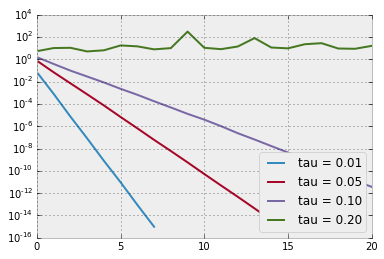

In [60]:
N = 200

# Create a random b
b = np.random.random(N)
# Initial guess at x
x0 = np.ones(N)

tau = 0.01
A = getA(N, tau = tau)
print('Condition number (tau = %0.3f): ' % tau, np.linalg.cond(A))
x, res = cg(A, b, x0, tol = 1e-15)
plt.plot(res, label = 'tau = %0.2f' % tau)

tau = 0.05
A = getA(N, tau = tau)
print('Condition number (tau = %0.3f): ' % tau, np.linalg.cond(A))
x, res = cg(A, b, x0, tol = 1e-15)
plt.plot(res, label = 'tau = %0.2f' % tau)

tau = 0.1
A = getA(N, tau = tau)
print('Condition number (tau = %0.3f): ' % tau, np.linalg.cond(A))
x, res = cg(A, b, x0, tol = 1e-15)
plt.plot(res, label = 'tau = %0.2f' % tau)

tau = 0.2
A = getA(N, tau = tau)
print('Condition number (tau = %0.3f): ' % tau, np.linalg.cond(A))
x, res = cg(A, b, x0, tol = 1e-15)
plt.plot(res, label = 'tau = %0.2f' % tau)

plt.yscale('log')
plt.legend(loc = 'lower right')
plt.xlim(0, 20)

## Preconditioning

In [68]:
# Callback to get number of iterations from BicGStab
def f(x):
    global i
    i += 1

N = 500
# Create test matrix according to Exercise 36.3, plus 0.5 I
# (see Trefethen, Numerical Linear Algebra, page 315)
A  = np.diag(0.5 + np.sqrt(np.arange(1, N+1)))
A += np.diag(np.ones(N-1),   k = -1)   + np.diag(np.ones(N-1),   k = +1)
A += np.diag(np.ones(N-100), k = -100) + np.diag(np.ones(N-100), k = +100)
# Create some b
b = np.ones(N)
# Initial guess at x
x0 = np.ones(N)

# Jacobi preconditioner, the inverse of the diagonal of A
P = np.diag(1/np.diag(A))

## BicGSstab ##
print('Solving with BicGStab')
i = 0
x,  info = linalg.bicgstab(A, b, x0, tol = 1e-15, callback = f)
print('Iterations without preconditioner: ', i)
i = 0
# bicgstab takes preconditioner as argument and applies it
xp, info = linalg.bicgstab(A, b, x0, tol = 1e-15, callback = f, M = P)
print('Iterations with preconditioner:    ', i)
# Verify that the solutions are "equal"
print('Are the two solutions close: ', np.allclose(x, xp, rtol = 1e-6, atol = 1e-6))

## Conjugate gradient ##
# Create preconditioned versions of A and b
Ap = np.dot(M, A)
bp = np.dot(M, b)

print('solving with conjugate gradient')
x,  res   = cg(A,  b,  x0, tol = 1e-6)
print('Iterations without preconditioner: ', len(res))
xp, res_P = cg(Ap, bp, x0, tol = 1e-6)
print('Iterations with preconditioner:    ', len(res_P))
print('Are the two solutions close: ', np.allclose(x, xp))

Solving with BicGStab
Iterations without preconditioner:  50
Iterations with preconditioner:     21
Are the two solutions close:  True
solving with conjugate gradient
Iterations without preconditioner:  43
Iterations with preconditioner:     30
Are the two solutions close:  True
